In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot
import tensorflow as tf
import pickle
import os

In [13]:
import dataset_utils
from glob import glob

In [14]:
DATA_DIR = "data/entire_field_raw_3_class"
NUM_POINTS = 100
NUM_CLASSES = 3
BATCH_SIZE = 32
train_points, test_points, train_labels, test_labels, CLASS_MAP = dataset_utils.parse_dataset(NUM_POINTS, DATA_DIR)

processing class: walking
processing class: speed_walking
processing class: jumping


In [15]:
print(train_points)

[[[ 1.992e+00  3.879e+00  2.012e+00  0.000e+00  1.290e+02]
  [ 7.046e-01  3.680e+00  1.196e+00  0.000e+00  1.300e+02]
  [ 4.250e+00  1.561e+00  1.455e+00 -6.260e-01  1.960e+02]
  ...
  [ 2.174e+00  2.742e+00  1.041e+00  0.000e+00  1.780e+02]
  [-5.254e-01  7.656e-01  1.973e-01 -2.505e-01  1.760e+02]
  [ 7.100e-01  4.559e+00  1.298e+00  0.000e+00  1.560e+02]]

 [[ 7.100e-01  4.559e+00  1.298e+00  0.000e+00  1.560e+02]
  [-5.254e-01  7.656e-01  1.973e-01 -2.505e-01  1.760e+02]
  [ 7.100e-01  4.555e+00  1.300e+00  0.000e+00  1.600e+02]
  ...
  [-5.254e-01  7.656e-01  1.973e-01 -2.505e-01  1.760e+02]
  [ 4.059e+00  1.826e+00  1.190e+00 -1.002e+00  1.510e+02]
  [ 7.100e-01  4.559e+00  1.299e+00  0.000e+00  1.660e+02]]

 [[-1.128e+00  1.377e+00  2.432e-01 -7.515e-01  1.680e+02]
  [-1.146e+00  3.988e+00  1.523e+00  7.515e-01  1.990e+02]
  [ 2.174e+00  2.742e+00  1.041e+00  0.000e+00  1.780e+02]
  ...
  [ 2.174e+00  2.740e+00  1.039e+00  0.000e+00  1.800e+02]
  [ 2.174e+00  2.742e+00  1.041e+0

In [16]:
print(test_points)

[[[ 7.046e-01  3.689e+00  1.187e+00  0.000e+00  1.330e+02]
  [ 7.998e-01  3.369e+00  1.313e+00  5.010e-01  3.100e+02]
  [ 1.992e+00  3.879e+00  2.016e+00  0.000e+00  1.280e+02]
  ...
  [ 7.520e-01  3.621e+00  1.261e+00  5.010e-01  3.530e+02]
  [ 1.992e+00  3.877e+00  2.020e+00  0.000e+00  1.320e+02]
  [ 3.082e+00  4.406e+00  1.799e+00  3.757e-01  1.240e+02]]

 [[ 2.174e+00  2.742e+00  1.038e+00  0.000e+00  1.810e+02]
  [ 2.613e+00  5.277e+00 -1.477e+00 -3.757e-01  1.660e+02]
  [ 4.168e+00  2.449e+00  1.695e+00 -3.757e-01  1.660e+02]
  ...
  [ 5.010e-01  1.967e+00  8.135e-01 -1.002e+00  2.660e+02]
  [ 6.240e-01  3.309e+00  1.106e+00  3.757e-01  1.420e+02]
  [ 7.046e-01  3.688e+00  1.188e+00  0.000e+00  1.330e+02]]

 [[ 7.046e-01  3.691e+00  1.183e+00  0.000e+00  1.320e+02]
  [ 3.008e+00  4.184e+00  1.690e+00  3.757e-01  1.420e+02]
  [ 4.807e-01  1.639e+00  1.026e+00 -7.515e-01  2.310e+02]
  ...
  [ 7.046e-01  3.680e+00  1.196e+00  0.000e+00  1.340e+02]
  [ 7.046e-01  3.680e+00  1.196e+0

In [17]:
# train_points = train_points[:, :, :3]
# test_points = test_points[:, :, :3]
print(CLASS_MAP)

{0: 'walking', 1: 'speed_walking', 2: 'jumping'}


In [18]:
from tensorflow import data as tf_data
import keras
import PointNET

keras.utils.set_random_seed(seed=42)

In [19]:
train_size = 0.8
dataset = tf_data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf_data.Dataset.from_tensor_slices((test_points, test_labels))
train_dataset_size = int(len(dataset) * train_size)

dataset = dataset.shuffle(len(train_points)).map(PointNET.augment)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

train_dataset = dataset.take(train_dataset_size).batch(BATCH_SIZE)
validation_dataset = dataset.skip(train_dataset_size).batch(BATCH_SIZE)

In [20]:
import keras
import tensorflow as tf
from keras import ops
from keras import layers
from PointNET import tnet, conv_bn, dense_bn

In [21]:
inputs = keras.Input(shape=(NUM_POINTS, 5))

x = tnet(inputs, 5)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()

Model: "pointnet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 100, 5)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 100, 32)   │        192 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 32)   │        128 │ conv1d_11[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 100, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 100, 64)   │      2,112 │ activation_17[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 64)   │        256 │ conv1d_12[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 100, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 100, 512)  │     33,280 │ activation_18[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 512)  │      2,048 │ conv1d_13[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 100, 512)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ activation_19[0]… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 256)       │    131,328 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_9[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 256)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 128)       │     32,896 │ activation_20[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_10[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_21       │ (None, 128)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 25)        │      3,225 │ activation_21[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 5, 5)      │          0 │ dense_11[0][0]  

 Total params: 750,268 (2.86 MB)

 Trainable params: 744,188 (2.84 MB)

 Non-trainable params: 6,080 (23.75 KB)

In [24]:
from tensorflow.keras.callbacks import ModelCheckpoint
import os


In [25]:
INIT_TIMESTAMP = "2/09/2024"
checkpoint_dir = os.path.join('model/checkpoints/', INIT_TIMESTAMP)
os.makedirs(checkpoint_dir, exist_ok=True)

In [28]:
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'iter-{epoch:02d}.weights.h5'),  # Save weights after each epoch
    save_weights_only=True,  # Save only weights, not the entire model
    verbose=1  # Print a message when saving
)

In [29]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset,
    callbacks=[checkpoint_callback]  # Add the checkpoint callback here
)

Epoch 1/20
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 49.9554 - sparse_categorical_accuracy: 0.4982
Epoch 1: saving model to model/checkpoints/2/09/2024/iter-01.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 49.5037 - sparse_categorical_accuracy: 0.5066 - val_loss: 46.5355 - val_sparse_categorical_accuracy: 0.6466
Epoch 2/20
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 36.9375 - sparse_categorical_accuracy: 0.8412
Epoch 2: saving model to model/checkpoints/2/09/2024/iter-02.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 36.9189 - sparse_categorical_accuracy: 0.8420 - val_loss: 36.9087 - val_sparse_categorical_accuracy: 0.8198
Epoch 3/20
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 36.5928 - sparse_categorical_accuracy: 0.9059
Epoch 3: saving model to model/checkpoints/2/09/2024/iter-03.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 36.5726 - sparse_categorical_accuracy: 0.9071 - val_loss: 36.1697 - val_sparse_categorical_accuracy: 0.9647
E

In [30]:
from matplotlib import pyplot as plt

2024-09-02 01:09:01.396661: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
[[[ 1.103e+00  4.016e+00 -8.926e-01 -8.765e-01  1.610e+02]
  [ 9.072e-01  1.553e+00  1.097e+00  3.757e-01  1.940e+02]
  [ 7.100e-01  4.551e+00  1.301e+00  0.000e+00  1.630e+02]
  ...
  [ 2.174e+00  2.740e+00  1.046e+00  0.000e+00  1.790e+02]
  [-8.359e-01  3.006e+00  1.260e+00  7.515e-01  1.910e+02]
  [ 6.719e-01  3.039e+00  1.193e+00 -1.002e+00  2.860e+02]]

 [[ 2.174e+00  2.740e+00  1.043e+00  0.000e+00  1.770e+02]
  [ 1.264e+00  1.354e+00  9.541e-01 -2.505e-01  2.240e+02]
  [ 1.081e+00  3.029e+00  3.789e-01  3.757e-01  2.750e+02]
  ...
  [-1.098e+00  1.824e+00  8.418e-01  8.765e-01  1.700e+02]
  [ 7.046e-01  3.684e+00  1.194e+00  0.000e+00  1.300e+02]
  [ 7.046e-01  3.688e+00  1.189e+00  0.000e+00  1.330e+02]]

 [[ 1.992e+00  3.877e+00  2.016e+00  0.000e+00  1.340e+02]
  [ 7.100e-01  4.551e+00  1.301e+00  0.000e+00  1.620e+02]
  [ 1.992e+00  3.879e+00  2.010e+00  0.000e+00  1.300e+02]
  ...
  [-7.266e-01  1.758e+00  1.482e+00  7.515e-01  1.870e

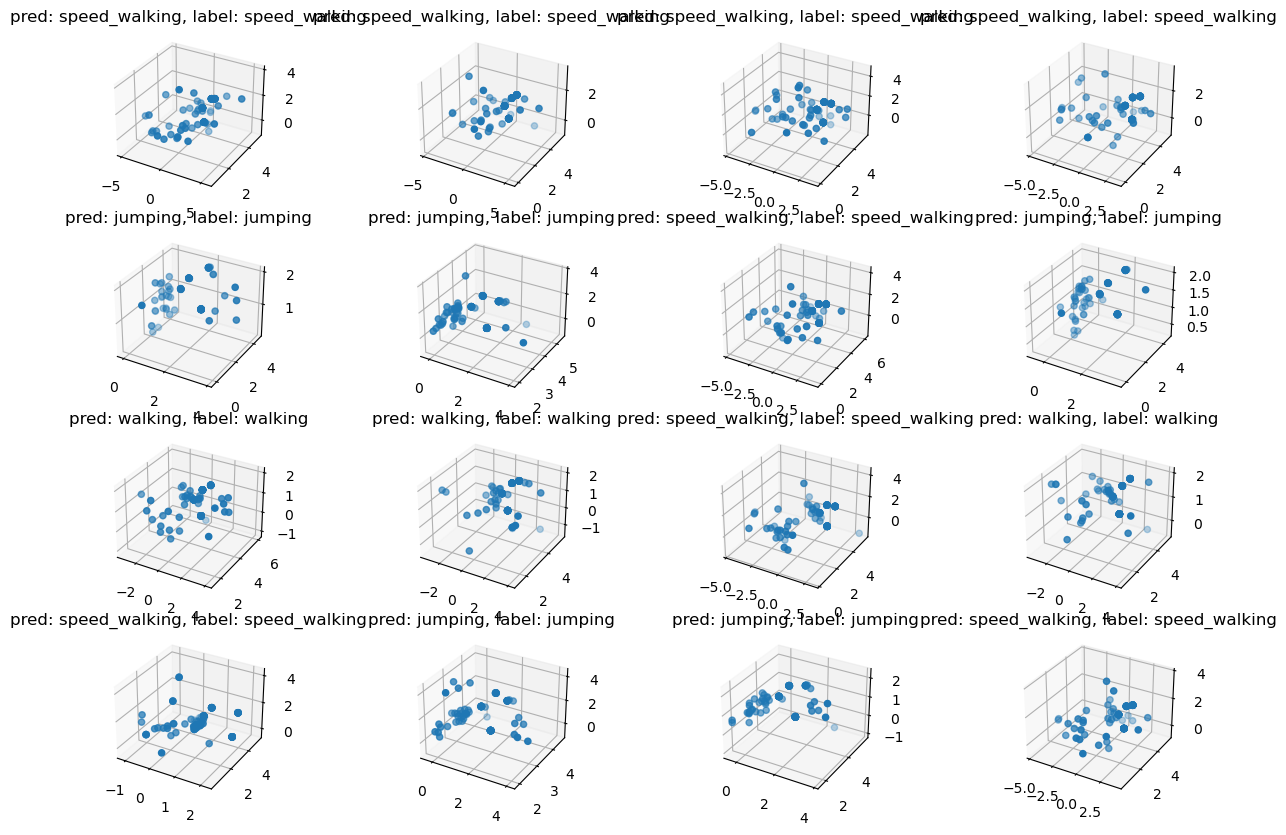

In [31]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:20, ...]
labels = labels[:20, ...]

# run test data through model
preds = model.predict(points)
preds = ops.argmax(preds, -1)

points = points.numpy()
print(points)

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_on()
plt.show()

In [32]:
predictions = []

# Calculate the number of sections, ensure it's at least 1
num_sections = max(1, len(test_points) // NUM_POINTS)

for batch in np.array_split(test_points, num_sections): 
    preds = model.predict(batch)
    preds = np.argmax(preds, axis=-1)
    predictions.extend(preds)

predictions = np.array(predictions)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [33]:
accuracy = np.sum(predictions == test_labels) / len(test_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 95.48%


In [34]:
print(test_labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


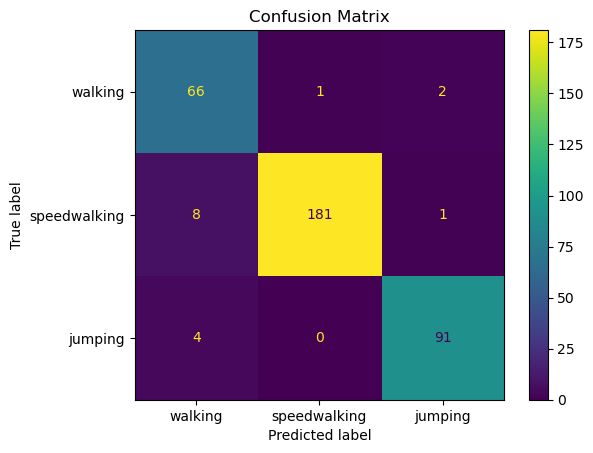

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Plotting the confusion matrix
# Compute the confusion matrix
cm = confusion_matrix(test_labels, predictions)

# Plotting the confusion matrix
class_names = ['walking', 'speedwalking', 'jumping']  # Based on your CLASS_MAP
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)

# Display the plot
disp.plot()
plt.title("Confusion Matrix")
plt.show()


In [37]:
#reload model
reload_model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
reload_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

In [38]:
reload_model.load_weights('model/checkpoints/2_09_2024/iter-20.weights.h5')

/Users/katiezhou/mambaforge/envs/py38/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 150 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
